<a href="https://www.kaggle.com/code/eduardojst10/energy-model?scriptVersionId=199379702" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import matplotlib.pyplot as plt
import keras_tuner as kt
import os

In [2]:
df = pd.read_csv('/kaggle/input/electricityloaddiagrams20112014/df_kwh_adjusted.csv', sep=';', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [3]:
df.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.0,140256.0,140256.0,140256.000000,140256.000000,140256.000000,140256.0,140256.0,140256.0,140256.000000,...,140256.0,140256.000000,140256.000000,140256.000000,140256.0,140256.0,140256.0,140256.0,140256.000000,140256.000000
mean,0.0,0.0,0.0,0.026291,0.281984,0.813468,0.0,0.0,0.0,0.072902,...,0.0,9390.235177,2.110427,68.284958,0.0,0.0,0.0,0.0,0.446505,58.208918
std,0.0,0.0,0.0,1.281609,1.975930,6.413715,0.0,0.0,0.0,1.348057,...,0.0,9681.456909,43.179433,298.676252,0.0,0.0,0.0,0.0,9.740849,510.117704
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
50%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,6025.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
75%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,13700.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
max,0.0,0.0,0.0,62.500000,37.500000,125.000000,0.0,0.0,0.0,25.000000,...,0.0,48200.000000,1750.000000,2500.000000,0.0,0.0,0.0,0.0,312.500000,6600.000000


Split the data

time series forecasting:
- Training set: first 70% of data
- Validation set: the next 15%
- Test set: the final 15%

In [4]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)


df_train = df.iloc[:train_size]
df_val = df.iloc[train_size:train_size+val_size]
df_test = df.iloc[train_size+val_size:]

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), 
                               columns=df_train.columns, 
                               index=df_train.index)

df_val_scaled = pd.DataFrame(scaler.transform(df_val), 
                             columns=df_val.columns, 
                             index=df_val.index)

df_test_scaled = pd.DataFrame(scaler.transform(df_test), 
                               columns=df_test.columns, 
                               index=df_test.index)

In [6]:
sequence_length = 96  # 24 hours * 4 (15-minute intervals)

# Use timeseries_dataset_from_array to generate datasets
def create_tf_dataset(X, y=None, batch_size=256):
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=X,
        targets=y,
        sequence_length=sequence_length,
        shuffle=True,
        batch_size=batch_size
    )
    return dataset

In [7]:
X_train, y_train = df_train_scaled.to_numpy(), df_train_scaled.to_numpy()[sequence_length:]
X_val, y_val = df_val_scaled.to_numpy(), df_val_scaled.to_numpy()[sequence_length:]
X_test, y_test = df_test_scaled.to_numpy(), df_test_scaled.to_numpy()[sequence_length:]

In [8]:
train_dataset = create_tf_dataset(X_train, y_train, batch_size=264)
val_dataset = create_tf_dataset(X_val, y_val, batch_size=264)
test_dataset = create_tf_dataset(X_test, y_test, batch_size=264)
print("Training set shape:", X_train.shape)
print("Training set shape:", y_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (98179, 370)
Training set shape: (98083, 370)
Validation set shape: (21038, 370)
Testing set shape: (21039, 370)


In [9]:
train_dataset.element_spec

(TensorSpec(shape=(None, None, 370), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 370), dtype=tf.float64, name=None))

In [10]:
for batch in train_dataset.take(1):
    inputs, targets = batch
    print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
    
input_shape = (96, 370)  # 96 timesteps, 370 features (clients)
output_shape = 370   

Input shape: (264, 96, 370), Target shape: (264, 370)


Model - LSTM

using **one day of data (96 time steps, each 15 minutes)** from **370 clients** to predict the **next 15-minute consumption** for all 370 clients.

In [11]:
def lstm_model(input_shape, output_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    # First LSTM layer (with return sequences to pass to next LSTM)
    model.add(tf.keras.layers.LSTM(200, activation='relu', input_shape=input_shape, return_sequences=True))
    
    # Add a dropout layer for regularization
    model.add(Dropout(0.3))
    
    # Second LSTM layer
    model.add(tf.keras.layers.LSTM(50, activation='relu', return_sequences=True))
    
    # Dropout again
    model.add(Dropout(0.4))
    
    # Third LSTM layer (if you want even more depth)
    model.add(tf.keras.layers.LSTM(20, activation='relu'))
    
    # Dropout
    model.add(Dropout(0.3))
    
    # Dense layer to reduce dimensionality and combine features
    model.add(tf.keras.layers.Dense(20, activation='relu'))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=output_shape))
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model



def lstm_model2(input_shape, output_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    # First LSTM layer (with return sequences to pass to next LSTM)
    model.add(tf.keras.layers.LSTM(100, activation='relu', input_shape=input_shape, return_sequences=True))
    
    # Add a dropout layer for regularization
    model.add(Dropout(0.3))
    
    # Second LSTM layer
    model.add(tf.keras.layers.LSTM(50, activation='relu', return_sequences=True))
    
    # Dropout again
    model.add(Dropout(0.3))
    
    # Third LSTM layer (if you want even more depth)
    model.add(tf.keras.layers.LSTM(20, activation='relu'))
    
    # Dropout
    model.add(Dropout(0.3))
    
    # Dense layer to reduce dimensionality and combine features
    model.add(tf.keras.layers.Dense(20, activation='relu'))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=output_shape))
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


def lstm_model_tuner(hp):
    model = Sequential()

    # Input Layer
    input_shape = (96, 370)  # Example input shape (adjust based on your data)
    model.add(Input(shape=input_shape))
    
    # First LSTM Layer
    model.add(LSTM(units=hp.Int('units_lstm1', min_value=50, max_value=200, step=50),
                   activation='relu', return_sequences=True))
    model.add(Dropout(hp.Float('dropout_lstm1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Second LSTM Layer
    model.add(LSTM(units=hp.Int('units_lstm2', min_value=50, max_value=150, step=50),
                   activation='relu', return_sequences=True))
    model.add(Dropout(hp.Float('dropout_lstm2', min_value=0.2, max_value=0.5, step=0.1)))

    # Third LSTM Layer
    model.add(LSTM(units=hp.Int('units_lstm3', min_value=20, max_value=100, step=20),
                   activation='relu'))
    model.add(Dropout(hp.Float('dropout_lstm3', min_value=0.2, max_value=0.5, step=0.1)))

    # Dense Layer
    model.add(Dense(units=hp.Int('dense_units', min_value=20, max_value=100, step=20), activation='relu'))
    
    # Output Layer
    output_shape = 370  # Example output shape (based on your task)
    model.add(Dense(units=output_shape))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4]))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

input - sequences of **96 time steps** (representing one day of 15-minute intervals) for **370 clients** (features)

target - **next 15-minute consumptio**n for all **370 clients** (output)

In [12]:
model = lstm_model(input_shape,output_shape)
model.summary()
model2 = lstm_model2(input_shape,output_shape)
model2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 96, 200)        │       456,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96, 50)         │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 370)            │         7,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,870 (1.99 MB)

 Trainable params: 520,870 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 96, 100)        │       188,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 96, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 370)            │         7,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,470 (908.09 KB)

 Trainable params: 232,470 (908.09 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
if not os.path.exists('/kaggle/working'):
    os.makedirs('/kaggle/working')

model_checkpoint_path = '/kaggle/working/best_model.keras'
csv_logger_path = '/kaggle/working/training_log.csv'

# Callbacks
callbacks = [
    # Early stopping to stop training if the validation loss does not improve
    #tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True),
    
    # Reduce learning rate when a metric has stopped improving
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=10),
    
    # Save the best model during training
    ModelCheckpoint(filepath=model_checkpoint_path, save_best_only=True, monitor='val_loss', mode='min'),
    
    # Log the training data into a CSV file
    CSVLogger(csv_logger_path)
]

In [14]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

import json
with open("/kaggle/working/history.json", "w") as f:
    json.dump(history.history, f)

Epoch 1/50


I0000 00:00:1727975291.725462      65 service.cc:145] XLA service 0x5cdbd33bad50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727975291.725546      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/372 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - loss: 0.0026 - mae: 0.0058   

I0000 00:00:1727975299.106160      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


372/372 ━━━━━━━━━━━━━━━━━━━━ 56s 118ms/step - loss: 0.0025 - mae: 0.0091 - val_loss: 0.0238 - val_mae: 0.0089 - learning_rate: 0.0010
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - loss: 0.0023 - mae: 0.0079 - val_loss: 0.0238 - val_mae: 0.0088 - learning_rate: 0.0010
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - loss: 0.0023 - mae: 0.0075 - val_loss: 0.0238 - val_mae: 0.0087 - learning_rate: 0.0010
Epoch 4/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - loss: 0.0023 - mae: 0.0074 - val_loss: 0.0238 - val_mae: 0.0090 - learning_rate: 0.0010
Epoch 5/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - loss: 0.0023 - mae: 0.0074 - val_loss: 0.0239 - val_mae: 0.0091 - learning_rate: 0.0010
Epoch 6/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - loss: 0.0022 - mae: 0.0074 - val_loss: 0.0240 - val_mae: 0.0093 - learning_rate: 0.0010
Epoch 7/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - loss: 0.0022 - mae: 0.0074 - val_loss: 196.7944 - val_mae: 0.1065 - learning_rate: 0.0010


In [15]:
history2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Adjust as needed
    callbacks=callbacks
)

# Save training history

with open("/kaggle/working/history2.json", "w") as f:
    json.dump(history.history, f)

Epoch 1/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - loss: 0.0022 - mae: 0.0071 - val_loss: 3368846488085391736832.0000 - val_mae: 1677253504.0000 - learning_rate: 1.6000e-06
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - loss: 0.0022 - mae: 0.0071 - val_loss: 1528660058480599629824.0000 - val_mae: 1366846976.0000 - learning_rate: 1.6000e-06
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - loss: 0.0022 - mae: 0.0071 - val_loss: 6098236435229654908928.0000 - val_mae: 1979555328.0000 - learning_rate: 1.6000e-06
Epoch 4/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - loss: 0.0022 - mae: 0.0071 - val_loss: 1876506975437116669952.0000 - val_mae: 1360774400.0000 - learning_rate: 1.6000e-06
Epoch 5/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - loss: 0.0022 - mae: 0.0071 - val_loss: 1484425702940566618112.0000 - val_mae: 1530204928.0000 - learning_rate: 1.6000e-06
Epoch 6/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step - loss: 0.0022 - mae: 0.0071 - val_loss: 248698820080067

In [16]:
tuner = kt.RandomSearch(
    lstm_model_tuner,
    objective='val_loss',  # You want to minimize validation loss
    max_trials=5,          # Number of models to try
    executions_per_trial=1, # Number of times to repeat each model for better accuracy
    directory='my_dir',
    project_name='lstm_tuning'
)


In [17]:
#tuner.search(train_dataset,
#             validation_data=val_dataset,
#             epochs=10,
#             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])  # Adjust patience as needed


# test

### COMPARISON BETWEEN MODELS

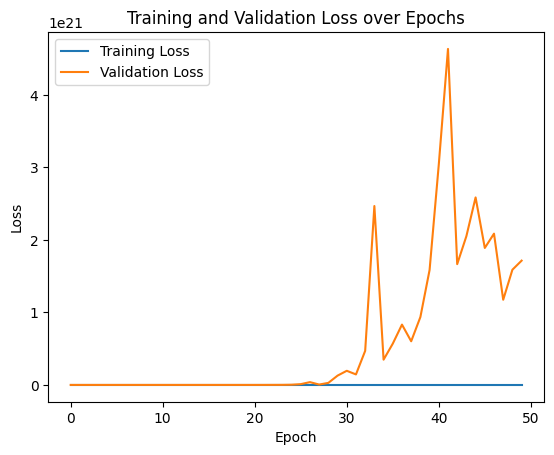

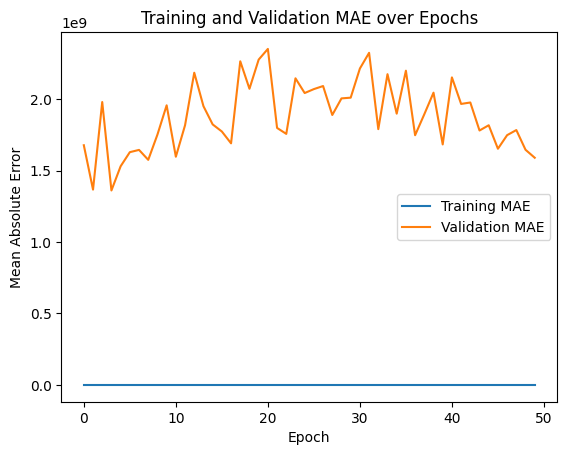

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation MAE
plt.plot(history2.history['mae'], label='Training MAE')
plt.plot(history2.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

## Normal model evaluation

In [19]:
test_loss, test_mae = model.evaluate(test_dataset)

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 5252622752954444702285824.0000 - mae: 58592038912.0000


In [20]:
print(f'Test loss: {test_loss}')

Test loss: 8.845686481160619e+24


In [21]:
print(f'Test MAE: {test_mae}')

Test MAE: 75895406592.0


In [22]:
import os

log_path = '/kaggle/working/best_model.keras'

# Check if the file exists
if os.path.exists(log_path):
    print(f"File {log_path} exists.")
    if os.path.getsize(log_path) > 0:
        print("File has data.")
    else:
        print("File is empty.")
else:
    print(f"File {log_path} does not exist.")


File /kaggle/working/best_model.keras exists.
File has data.


In [23]:
log_path = '/kaggle/input/energy-model-v2-0-4-output/training_log.csv'
training_log = pd.read_csv(log_path)

# Display the first few rows
print(training_log.head())

   epoch  learning_rate      loss       mae      val_loss      val_mae
0      0         0.0005  0.002298  0.008231  2.372554e-02     0.008791
1      1         0.0005  0.002246  0.007653  2.373913e-02     0.008803
2      2         0.0005  0.002236  0.007574  2.374092e-02     0.008925
3      3         0.0005  0.002228  0.007443  2.375488e-02     0.008866
4      4         0.0005  0.002225  0.007371  1.233653e+12  8238.721680


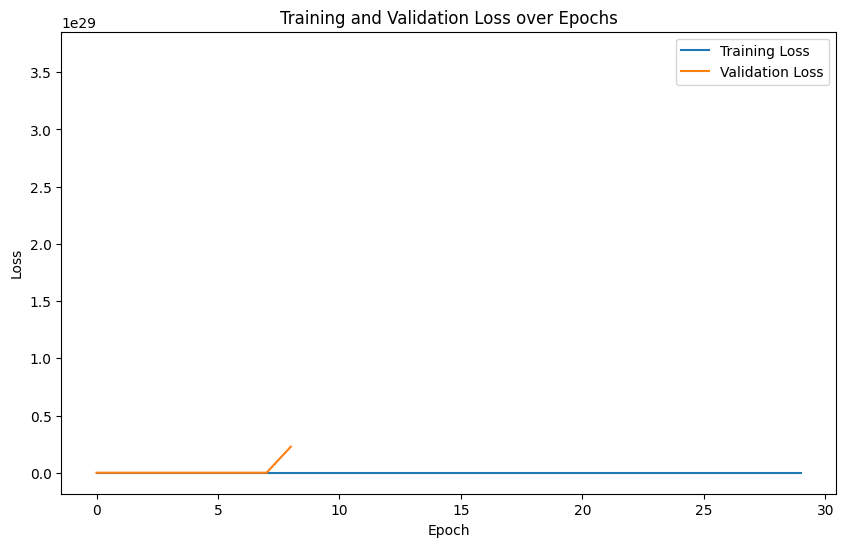

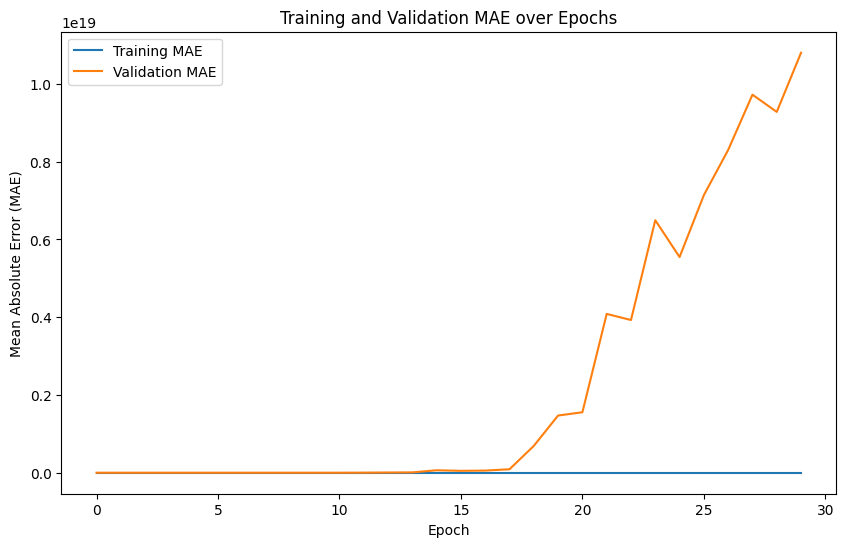

In [24]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_log['epoch'], training_log['loss'], label='Training Loss')
plt.plot(training_log['epoch'], training_log['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot additional metrics if available (like MAE)
if 'mae' in training_log.columns and 'val_mae' in training_log.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(training_log['epoch'], training_log['mae'], label='Training MAE')
    plt.plot(training_log['epoch'], training_log['val_mae'], label='Validation MAE')
    plt.title('Training and Validation MAE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()
    plt.show()

Evaluate model prediction

In [25]:
# Load the best model
model_path = '/kaggle/input/energy-model-v2-0-4-output/best_model.keras'
model = tf.keras.models.load_model(model_path)

# Evaluate on the test set
test_loss, test_mae = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

# Predict on a sample from the test set
sample_predictions = model.predict(test_dataset)

80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.2531 - mae: 0.0118
Test Loss: 0.234041228890419
Test MAE: 0.011798304505646229
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step


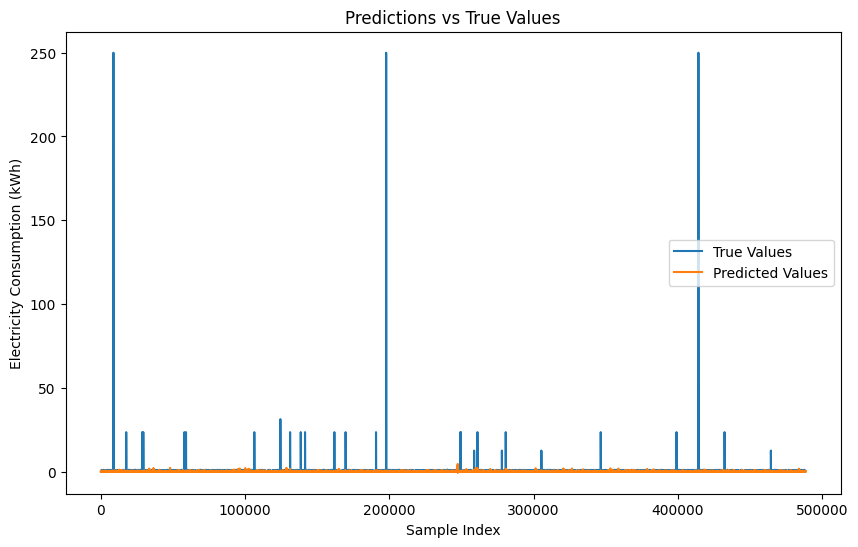

In [26]:
y_test_samples = np.concatenate([y for x, y in test_dataset.take(5)], axis=0)
pred_samples = sample_predictions[:len(y_test_samples)]

plt.figure(figsize=(10, 6))
plt.plot(y_test_samples.flatten(), label='True Values')
plt.plot(pred_samples.flatten(), label='Predicted Values')
plt.title('Predictions vs True Values')
plt.xlabel('Sample Index')
plt.ylabel('Electricity Consumption (kWh)')
plt.legend()
plt.show()

## Hyperparameter tuner model

In [27]:
#best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
#print(f"The best number of units in the  LSTM1 layer is {best_hps.get('units_lstm1')}")
#print(f"The best number of units in the  dropout1 layer is {best_hps.get('dropout_lstm1')}")
#print(f"The best number of units in the LSTM2 layer is {best_hps.get('units_lstm2')}")
#print(f"The best number of units in the  dropout2 layer is {best_hps.get('dropout_lstm2')}")
#print(f"The best number of units in the LSTM3 layer is {best_hps.get('units_lstm3')}")
#print(f"The best number of units in the  dropout3 layer is {best_hps.get('dropout_lstm3')}")
#print(f"The best number of units in the dense layer is {best_hps.get('dense_units')}")
#print(f"The best learning rate for the optimizer is {best_hps.get('learning_rate')}")